In [5]:
def heaviside(x):
        if x < 0:
            return 0
        else:
            return 1


def format_time(seconds: int)->str:
        days = seconds // (24 * 60 * 60)
        hours = (seconds % (24 * 60 * 60)) // (60 * 60)
        minutes = (seconds % (60 * 60)) // 60
        seconds = seconds % 60

        time_string = ""
        if days > 0:
            time_string += f"{days} day{'s' if days > 1 else ''}, "
        if hours > 0:
                time_string += f"{hours} hour{'s' if hours > 1 else ''}, "
        if minutes > 0:
            time_string += f"{minutes} minute{'s' if minutes > 1 else ''}, "
        if seconds > 0:
            time_string += f"{seconds} second{'s' if seconds > 1 else ''}"

        return time_string.rstrip(", ")
    

In [6]:
import math

from matplotlib import pyplot as plt
import numpy as np
from Utils import heaviside



class Plan:

    s_month = 3600 * 24 * 30

    def __init__(self, name: str, rate: int, rate_unit: int, quote: int, quote_unit: int, price:float, billing_unit:int=s_month, overage_cost:int=0):
        """
        Inicializa un objeto Plan con los valores proporcionados.

        Args:
            name (str): El nombre del plan.
            rate (int): El rate del plan.
            rate_unit (int): La unidad de tiempo del rate.
            quote (int): La cuota del plan.
            quote_unit (int): La unidad de tiempo de la cuota.
            price (float): El precio del plan.
            billing_unit (int): La unidad de tiempo para la facturación. cambiar por tiempo de facturación
            overage_cost (int): El precio por cada peticion que exceda la quota.
        """
        self._name= name
        self._rate= rate
        self._rate_unit = rate_unit
        self._quote= quote
        self._quote_unit = quote_unit
        self._price= price
        self._billing_unit= billing_unit
        self._overage_cost= overage_cost
        assert quote_unit > rate_unit, "Quote should be defined on a unit of time greater than rate"

    #Getters and Setters
    @property
    def name(self):
        return self._name

    @name.setter
    def name(self, value):
        self._name = value

    @property
    def rate(self):
        return self._rate

    @rate.setter
    def rate(self, value):
        self._rate = value

    @property
    def rate_unit(self):
        return self._rate_unit

    @rate_unit.setter
    def rate_unit(self, value):
        self._rate_unit = value

    @property
    def quote(self):
        return self._quote

    @quote.setter
    def quote(self, value):
        self._quote = value

    @property
    def quote_unit(self):
        return self._quote_unit

    @quote_unit.setter
    def quote_unit(self, value):
        self._quote_unit = value

    @property
    def price(self):
        return self._price

    @price.setter
    def price(self, value):
        self._price = value

    @property
    def billing_unit(self):
        return self._billing_unit

    @billing_unit.setter
    def billing_unit(self, value):
        self._billing_unit = value

    @property
    def overage_cost(self):
        return self._overage_cost

    @overage_cost.setter
    def overage_cost(self, value):
        self._overage_cost = value
    

    def capacity(self, time: int) -> float:
        """
        Calculates the capacity at a given time.

        Args:
            time (int): The time at which the capacity is calculated.

        Returns:
            float: The capacity at the given time.
        """
        
        assert self._quote is not None and self._rate is not None and self._quote_unit is not None and self._rate_unit is not None, "Variables quote, rate, quote_unit, and rate_unit must be defined before capacity is called"

        T = time - math.floor(time / self._quote_unit) * self._quote_unit
        tt = (self._quote / self._rate) * self._rate_unit  # t*
        A = math.ceil((time - tt) / self._quote_unit) * self._quote
        B = heaviside(tt - T) * (T / self._rate_unit) * self._rate
        return A + B
    

    def maximum_disruption_period(self) -> int:
        """
        Calculates the maximum disruption period.

        Returns:
            int: The maximum disruption period.
        """
        assert self._quote is not None and self._rate is not None and self._quote_unit is not None and self._rate_unit is not None, "Variables quote, rate, quote_unit, and rate_unit must be defined before maximum_disruption_period is called"

        tt = (self._quote / self._rate) * self._rate_unit
        tq = self._quote_unit
        return tq - tt

    def max_time_to_consume_at(self, rate: int) -> int:
        """
        Calculates the maximum time to consume at a given rate.

        Args:
            rate (int): The rate at which the maximum time to consume is calculated.

        Returns:
            int: The maximum time to consume at the given rate.
        """
        assert rate <= self._rate, "The rate must be less than or equal to the plan's rate."
        assert rate >= self._quote / self._quote_unit, "The rate must be greater than or equal to the plan's quote rate."
        
        tt =(self._quote / rate) * self._rate_unit
        return tt
    
    #Se descartará
    def rate(self, time: int) -> float:
        """
        Calculates the rate at a given time.

        Args:
            time (int): The time at which the rate is calculated.

        Returns:
            float: The rate at the given time.
        """
        return self._rate * time / self._rate_unit

    #Se descartará
    def quote(self, time: int) -> float:
        """
        Calculates the quote at a given time.

        Args:
            time (int): The time at which the quote is calculated.

        Returns:
            float: The quote at the given time.
        """
        return math.ceil(time/self._quote_unit)*self._quote
    
    def cost(self, time: int, requests: int) -> float:
        """
        Calculates the cost at a given time and with a number of requests.

        Args:
            time (int): The time at which the cost is calculated.
            requests (int): The number of requests.

        Returns:
            float: The cost at the given time and with the given number of requests.
        """
        C_0=self._price
        C_1=self._overage_cost
        plan_capacity = self.capacity(time)

        if requests > plan_capacity:
            return -1
        return C_0 * (math.ceil(time/self._billing_unit)) + heaviside(requests-self.capacity(time))*C_1*(requests-self.capacity(time))
        
    
    def plot_capacity(self, total_seconds: int)->None:
        x_val = np.linspace(0, total_seconds, 10000)  # Ejemplo de valores x (puedes ajustarlos según tus necesidades)
        capacity_values = np.vectorize(self.capacity)(x_val)  # Ejemplo de cálculo de capacidad según los valores x

        # Crear la gráfica
        plt.plot(x_val, capacity_values, label=self._name)
        plt.xlabel('Tiempo')
        plt.ylabel('Capacidad')
        plt.title('Capacidad del plan')
        plt.show()

    def plot_rate(self, total_seconds: int)->None:
        x_val = np.linspace(0, total_seconds, 10000)  # Ejemplo de valores x (puedes ajustarlos según tus necesidades)
        rate_values = np.vectorize(self.rate)(x_val)  # Ejemplo de cálculo de rate según los valores x

        # Crear la gráfica
        plt.plot(x_val, rate_values)
        plt.xlabel('Tiempo')
        plt.ylabel('Rate')
        plt.title('Rate del plan')
        plt.show()
    
    def plot_quote(self, total_seconds: int)->None:
        x_val = np.linspace(0, total_seconds, 10000)  # Ejemplo de valores x (puedes ajustarlos según tus necesidades)
        quote_values = np.vectorize(self.quote)(x_val)  # Ejemplo de cálculo de quote según los valores x

        # Crear la gráfica
        plt.plot(x_val, quote_values)
        plt.xlabel('Tiempo')
        plt.ylabel('Quote')
        plt.title('Quote del plan')
        plt.show()


    def plot_cost(self) -> None:
        t_max = 10
        req_max = 1000
        n = 1000
        n_levels = 10

        t_vec = np.linspace(0, t_max, n)
        req_vec = np.linspace(0, req_max, n)

        t_surf, req_surf = np.meshgrid(t_vec, req_vec)

        t_q = 7
        t_r = 1
        r = 100
        q = 500
        p_v = 1
        p_0 = 100

        t_star = q / r * t_r

        A = lambda t: np.ceil((t - t_star) / t_q) * q
        T = lambda t: t - np.floor(t / t_q) * t_q
        B = lambda t: np.heaviside(t_star - T(t), 0) * T(t) / t_r * r
        Max_Capacity = lambda t: A(t) + B(t)

        g = lambda t, req: p_v * (req - Max_Capacity(t))
        Cost = lambda t, req: p_0 + np.heaviside(req - Max_Capacity(t), 0) * g(t, req)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        z_values = Cost(t_surf, req_surf)
        z_values = np.where(np.isfinite(z_values), z_values, 0)
        ax.plot_surface(t_surf, req_surf, z_values, edgecolor='none', alpha=0.3)

        ax.contour(t_surf, req_surf, z_values, zdir='z', offset=-10, cmap='coolwarm')
        ax.contour(t_surf, req_surf, z_values, zdir='x', offset=-10, cmap='coolwarm')
        ax.contour(t_surf, req_surf, z_values, zdir='y', offset=1000, cmap='coolwarm')

        ax.set(xlim=(-10, t_max+10), ylim=(10, req_max+10), zlim=(-10, np.max(z_values)+10),
            xlabel='t (days)', ylabel='Requests', zlabel='Cost')

        plt.show()

In [7]:
from Utils import format_time
from Plans import *

s_day = 3600 * 24
s_month = 3600 * 24 * 30

Plan1 = Plan('Basic', 10, 1, 50, s_day, 0, s_month, 0.001)
Plan2 = Plan('Pro', 10, 1, 40000, s_month, 9.95, s_month, 0.001)
Plan3 = Plan('Ultra', 10, 1, 100000, s_month, 79.95, s_month, 0.00085)
Plan4 = Plan('Mega', 50, 1, 300000, s_month, 199.95, s_month, 0.00005)

plans = [Plan1, Plan2, Plan3, Plan4]

# Tiempo
t = 24*60*60*30
def test_capacity():
    for plan in plans:
        tqList = [t, t*2, t*3, t*4, t*5]
        for tq in tqList:
            assert plan.capacity(tq-1) <= plan.capacity(tq) < plan.capacity(tq+1), f"Error: Capacity condition not satisfied for tq = {tq} and plan = {plan._name}"
            print("\nRequests in a period of tq-1:", plan._name, ":", format_time(tq-1), ":", plan.capacity(tq-1))
            print("\nRequests in a period of tq:", plan._name, ":", format_time(tq), ":", plan.capacity(tq))
            print("\nRequests in a period of tq+1:", plan._name, ":", format_time(tq+1), ":", plan.capacity(tq+1))
            print('#-------------------------------------------------------------------------------------------#')


def test_max_time_to_consume_at():
    for plan in plans:
        for rate in range(int(plan._quote / plan._quote_unit)+1, int(plan._rate) + 1):
            tt = (plan._quote / rate) * plan._rate_unit
            assert plan.max_time_to_consume_at(rate) == tt, f"Error: max_time_to_consume_at condition not satisfied for rate = {rate} and plan = {plan.name}"
            print("\nPlan:", plan.name)
            print("\nRate:", rate)
            print("\nMaximum time to consume:", format_time(plan.max_time_to_consume_at(rate)))
            print("\nTo ensure that the calculation is correct, it should be: tt=", format_time(tt))
            print('#-------------------------------------------------------------------------------------------#')

def test_disruption_period():
    for plan in plans:
        tt = (plan._quote / plan._rate) * plan._rate_unit
        tq = plan._quote_unit
        assert plan.maximum_disruption_period() == tq-tt, f"Error: maximum_disruption_period condition not satisfied for plan = {plan.name}"
        print("\nPlan:", plan.name)
        print("\nMaximum disruption period:", format_time(plan.maximum_disruption_period()))
        print("\nTo ensure that the calculation is correct, it should be: tq-tt=", format_time(tq-tt))
        print('#-------------------------------------------------------------------------------------------#')


def test_cost():
    req=[50, 40000, 100000, 300000]
    for r in req:
        for plan in plans:
            assert plan.cost(plan._quote_unit, plan._quote) == plan._price, f"Error: cost condition not satisfied for plan = {plan.name}"
            print("\nNumber of requests:", r)
            print("\nPlan:", plan.name, "-->Price:", plan._price)
            if plan.cost(plan._quote_unit, r)==-1:
                print("\nCost: No es posible satisfacer la capacidad del plan en el tiempo establecido porque la capacidad en", format_time(plan._quote_unit), "es de", plan.capacity(plan._quote_unit), "requests.")    
            print("\nCost:", plan.cost(plan._quote_unit, r))
            print('#-------------------------------------------------------------------------------------------#')


##Graficas de capacidad, rate y quote

def test_plot_capacity():
    for plan in plans:
        plan.plot_capacity(s_month*2)

def test_plot_rate():
    for plan in plans:
        plan.plot_rate(1)

def test_plot_quote():
    for plan in plans:
        plan.plot_quote(s_day)

def test_plot_cost():
    Plan1.plot_cost()



if __name__ == '__main__':
    test_capacity()
    test_max_time_to_consume_at()
    test_disruption_period()
    test_cost()
    test_plot_capacity()
    test_plot_rate()
    test_plot_quote()
    test_plot_cost()


Requests in a period of tq-1: Basic : 29 days, 23 hours, 59 minutes, 59 seconds : 1500.0

Requests in a period of tq: Basic : 30 days : 1500.0

Requests in a period of tq+1: Basic : 30 days, 1 second : 1510.0
#-------------------------------------------------------------------------------------------#

Requests in a period of tq-1: Basic : 59 days, 23 hours, 59 minutes, 59 seconds : 3000.0

Requests in a period of tq: Basic : 60 days : 3000.0

Requests in a period of tq+1: Basic : 60 days, 1 second : 3010.0
#-------------------------------------------------------------------------------------------#

Requests in a period of tq-1: Basic : 89 days, 23 hours, 59 minutes, 59 seconds : 4500.0

Requests in a period of tq: Basic : 90 days : 4500.0

Requests in a period of tq+1: Basic : 90 days, 1 second : 4510.0
#-------------------------------------------------------------------------------------------#

Requests in a period of tq-1: Basic : 119 days, 23 hours, 59 minutes, 59 seconds : 6000

AttributeError: 'Plan' object has no attribute 'plot_capacity'

In [ ]:
# Q1. What is the maximum number of requests that can be made in 1 minute for each plan?
t=60
for plan in plans:
    print("\nThe maximum number of requests in a period of", format_time(t), "for plan", plan.name, "are:", plan.capacity(t), "requests" )


The maximum number of requests in a period of 1 minute for plan Basic are: 50.0 requests

The maximum number of requests in a period of 1 minute for plan Pro are: 600.0 requests

The maximum number of requests in a period of 1 minute for plan Ultra are: 600.0 requests

The maximum number of requests in a period of 1 minute for plan Mega are: 3000.0 requests


In [9]:
# Q3. What is the maximum number of requests that can be made in 1, 2 and 3 days?
t_List=[s_day, s_day*2, s_day*3]
for t in t_List:
    for plan in plans:
        print("\nThe maximum number of requests in a period of", format_time(t), "for plan", plan.name, "are:", int(plan.capacity(t)), "requests" )


The maximum number of requests in a period of 1 day for plan Basic are: 50 requests

The maximum number of requests in a period of 1 day for plan Pro are: 40000 requests

The maximum number of requests in a period of 1 day for plan Ultra are: 100000 requests

The maximum number of requests in a period of 1 day for plan Mega are: 300000 requests

The maximum number of requests in a period of 2 days for plan Basic are: 100 requests

The maximum number of requests in a period of 2 days for plan Pro are: 40000 requests

The maximum number of requests in a period of 2 days for plan Ultra are: 100000 requests

The maximum number of requests in a period of 2 days for plan Mega are: 300000 requests

The maximum number of requests in a period of 3 days for plan Basic are: 150 requests

The maximum number of requests in a period of 3 days for plan Pro are: 40000 requests

The maximum number of requests in a period of 3 days for plan Ultra are: 100000 requests

The maximum number of requests in 

In [8]:
#Q4. ¿Cúal es el tiempo máximo consumiendo a maxima velocidad de manera contuada para cada plan?

for plan in plans:
    tt = (plan._quote / plan._rate) * plan.rate_unit
    assert plan.max_time_to_consume_at(plan._rate) == tt, f"Error: max_time_to_consume_at condition not satisfied for rate = {plan._rate} and plan = {plan.name}"
    print("\nPlan:", plan.name)
    print("\nRate:", plan._rate)
    print("\nMaximum time to consume:", format_time(plan.max_time_to_consume_at(plan._rate)))


Plan: Basic

Rate: 10

Maximum time to consume: 5.0 seconds

Plan: Pro

Rate: 10

Maximum time to consume: 1.0 hour, 6.0 minutes, 40.0 seconds

Plan: Ultra

Rate: 10

Maximum time to consume: 2.0 hours, 46.0 minutes, 40.0 seconds

Plan: Mega

Rate: 50

Maximum time to consume: 1.0 hour, 40.0 minutes


In [ ]:
#Q5. Maximum disruption period for each plan

for plan in plans:
    tt = (plan._quote / plan._rate) * plan._rate_unit
    tq = plan._quote_unit
    assert plan.maximum_disruption_period() == tq-tt, f"Error: maximum_disruption_period condition not satisfied for plan = {plan.name}"
    print("\nPlan:", plan.name)
    print("\nMaximum disruption period:", format_time(plan.maximum_disruption_period()))
        


Plan: Basic

Maximum disruption period: 23.0 hours, 59.0 minutes, 55.0 seconds

Plan: Pro

Maximum disruption period: 29.0 days, 22.0 hours, 53.0 minutes, 20.0 seconds

Plan: Ultra

Maximum disruption period: 29.0 days, 21.0 hours, 13.0 minutes, 20.0 seconds

Plan: Mega

Maximum disruption period: 29.0 days, 22.0 hours, 20.0 minutes


In [ ]:
req=[50, 40000, 100000, 300000]
for r in req:
    for plan in plans:
        assert plan.cost(plan._quote_unit, plan._quote) == plan._price, f"Error: cost condition not satisfied for plan = {plan.name}"
        print("\nNumber of requests:", r)
        print("\nPlan:", plan.name, "-->Price:", plan._price)
        if plan.cost(plan._quote_unit, r)==-1:
            print("\nCost: No es posible satisfacer la capacidad del plan en el tiempo establecido porque la capacidad en", format_time(plan._quote_unit), "es de", plan.capacity(plan._quote_unit), "requests.")    
        print("\nCost:", plan.cost(plan._quote_unit, r))
        print('#-------------------------------------------------------------------------------------------#')


Number of requests: 50

Plan: Basic -->Price: 0

Cost: 0.0
#-------------------------------------------------------------------------------------------#

Number of requests: 50

Plan: Pro -->Price: 9.95

Cost: 9.95
#-------------------------------------------------------------------------------------------#

Number of requests: 50

Plan: Ultra -->Price: 79.95

Cost: 79.95
#-------------------------------------------------------------------------------------------#

Number of requests: 50

Plan: Mega -->Price: 199.95

Cost: 199.95
#-------------------------------------------------------------------------------------------#

Number of requests: 40000

Plan: Basic -->Price: 0

Cost: No es posible satisfacer la capacidad del plan en el tiempo establecido porque la capacidad en 1 day es de 50.0 requests.

Cost: -1
#-------------------------------------------------------------------------------------------#

Number of requests: 40000

Plan: Pro -->Price: 9.95

Cost: 9.95
#------------------

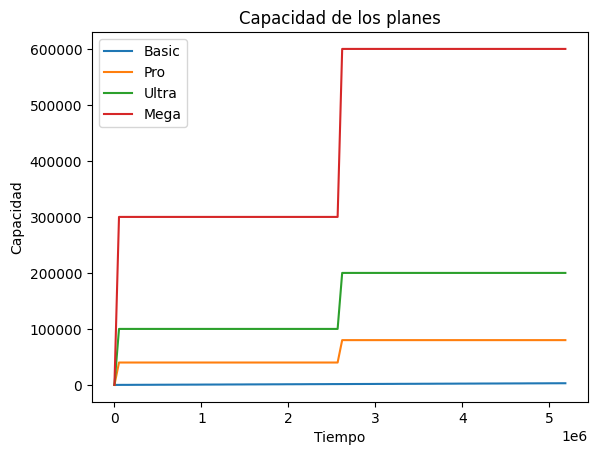

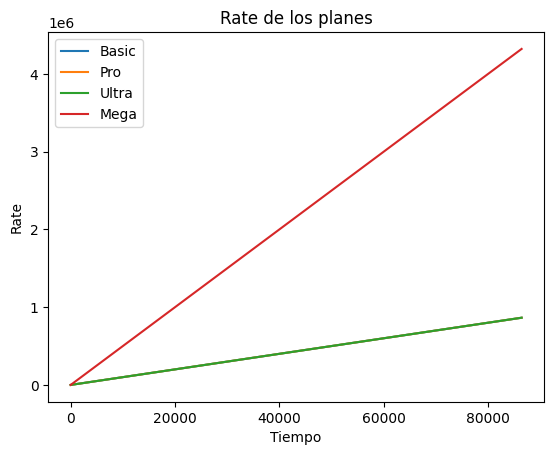

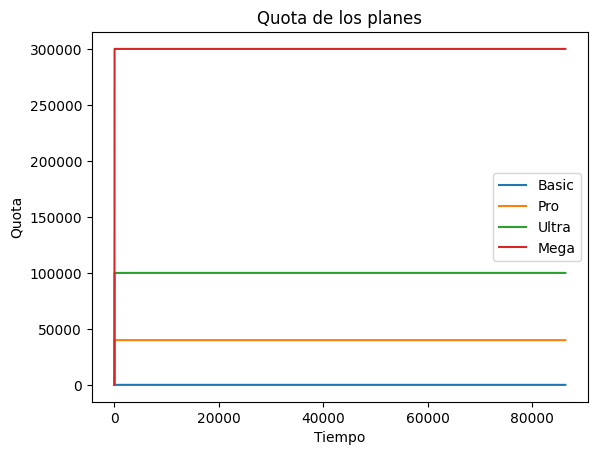

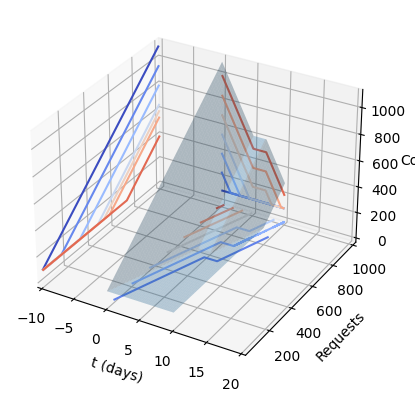

In [ ]:
def test_plot_capacity():
    x_val = np.linspace(0, s_month * 2, 100)  # Ejemplo de valores x (puedes ajustarlos según tus necesidades)

    for plan in plans:
        capacity_values = np.vectorize(plan.capacity)(x_val)  # Ejemplo de cálculo de capacidad según los valores x

        # Crear la gráfica
        plt.plot(x_val, capacity_values, label=plan.name)

    plt.xlabel('Tiempo')
    plt.ylabel('Capacidad')
    plt.title('Capacidad de los planes')
    plt.legend()
    plt.show()

def test_plot_rate():
    x_val = np.linspace(0, s_day, 10)  # Ejemplo de valores x (puedes ajustarlos según tus necesidades)

    for plan in plans:
        rate_values = np.vectorize(plan.rate)(x_val)  # Ejemplo de cálculo de la tasa según los valores x

        # Crear la gráfica
        plt.plot(x_val, rate_values, label=plan.name)

    plt.xlabel('Tiempo')
    plt.ylabel('Rate')
    plt.title('Rate de los planes')
    plt.legend()
    plt.show()

#Hacerlo simbolicamente
def test_plot_quote():
    x_val = np.linspace(0, s_day, 10000)  # Ejemplo de valores x (puedes ajustarlos según tus necesidades)

    for plan in plans:
        quote_values = np.vectorize(plan.quote)(x_val)  # Ejemplo de cálculo de la cotización según los valores x

        # Crear la gráfica
        plt.plot(x_val, quote_values, label=plan.name)

    plt.xlabel('Tiempo')
    plt.ylabel('Quota')
    plt.title('Quota de los planes')
    plt.legend()
    plt.show()

def test_plot_cost():

    t_max = 10
    req_max = 1000
    n = 1000
    n_levels = 10

    t_vec = np.linspace(0, t_max, n)
    req_vec = np.linspace(0, req_max, n)

    t_surf, req_surf = np.meshgrid(t_vec, req_vec)

    t_q = 7
    t_r = 1
    r = 100
    q = 500
    p_v = 1
    p_0 = 100

    t_star = q / r * t_r

    A = lambda t: np.ceil((t - t_star) / t_q) * q
    T = lambda t: t - np.floor(t / t_q) * t_q
    B = lambda t: np.heaviside(t_star - T(t), 0) * T(t) / t_r * r
    Max_Capacity = lambda t: A(t) + B(t)

    g = lambda t, req: p_v * (req - Max_Capacity(t))
    Cost = lambda t, req: p_0 + np.heaviside(req - Max_Capacity(t), 0) * g(t, req)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    z_values = Cost(t_surf, req_surf)
    z_values = np.where(np.isfinite(z_values), z_values, 0)
    ax.plot_surface(t_surf, req_surf, z_values, edgecolor='none', alpha=0.3)

    ax.contour(t_surf, req_surf, z_values, zdir='z', offset=-10, cmap='coolwarm')
    ax.contour(t_surf, req_surf, z_values, zdir='x', offset=-10, cmap='coolwarm')
    ax.contour(t_surf, req_surf, z_values, zdir='y', offset=1000, cmap='coolwarm')

    ax.set(xlim=(-10, t_max+10), ylim=(10, req_max+10), zlim=(-10, np.max(z_values)+10),
    xlabel='t (days)', ylabel='Requests', zlabel='Cost')

    plt.show()





if __name__ == '__main__':
    test_plot_capacity()
    test_plot_rate()
    test_plot_quote()
    test_plot_cost()